<div class = "alert alert-info>
              <h2>Imports</h2>
              </div>

<div class = "alert alert-info">
      <h2>Imports</h2>
                  </div>

In [1]:
# precise which gpu to use in the machine
# import os
# os.environ["CUDA_DEVICE_ORDER"]="0000:86:00.0"
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import os
import re
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers  import Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import layers
from keras import preprocessing


Using TensorFlow backend.


<div class = "alert alert-info">
    <h2>Prétraitement</h2>
    <h3>Extraction du genre, de la periode, division des oeuvres par actes, nettoyage des balises et suppression des mots vides</h3>
                  </div>

In [3]:
path = "corpus/theatreClassique/XML/"
liste = os.listdir(path)
stop_words = nltk.corpus.stopwords.words("french")
y = []
X = []
periode=[]

for texte in liste:
    
    try:

        f = open(path+texte,'r',encoding="utf-8")
        contenu = f.read()
        
    except UnicodeDecodeError:
        
        f = open(path+texte,'r',encoding="latin-1")
        contenu = f.read()
    
    contenu = contenu.lower()
    
    # division du texte par actes     
    acts = re.findall('<div1 .*?>(.*?)</div1>',contenu,flags=re.DOTALL)
    
    # extraction du genre. On suppose que tous les actes d'un meme texte possedent le meme genre.
    y += re.findall('<genre>(.*?)</genre>',contenu)*len(acts)
    
    # extraction de la periode. On suppose que tous les actes d'un meme texte possedent la meme periode.
    periode +=re.findall('<periode>(.*?)</periode>',contenu)*len(acts)

    for i in range(len(acts)):
        
        # elimination des balises
        acts[i] = re.sub('<.*?>', ' ', acts[i])
        
        # elimination des mots vides.
        acts[i] = re.sub(r'\b(' + r'|'.join(stop_words) + r')\b\s*','', acts[i])
        
        # subtitution des \n et \n\t qui existent une ou plusieurs fois consecutives par \n.
        acts[i] = re.sub("(\s*\n\t*\s*)", " \n ", acts[i])
        
        X.append(acts[i])
        
    f.close()

len(X),len(y)

(3156, 3156)

<div class = "alert alert-info">
      <h2>Choix des données relevantes et suppression des duplications</h2>
                  </div>

In [4]:
"""
mettre min_nb=200 pour avoir juste 3 classes ayant d'occurence plus que 200
""" 
min_nb = 10
classes = [x[0] for x in Counter(y).most_common() if x[1] >= min_nb]
print("On a {} classes qui existent au moins {} fois.".format(len(classes),min_nb))
classes

On a 20 classes qui existent au moins 10 fois.


['tragédie',
 'comédie',
 'tragi-comédie',
 'opéra',
 'drame',
 'proverbe',
 'pastorale',
 'comédie héroïque',
 'opuscule dramatique',
 'monologue',
 'tragédie en musique',
 'comédie-ballet',
 'farce',
 'opéra comique',
 'parodie',
 'pastorale héroïque',
 'tragédie lyrique',
 'ballet',
 'comédie galante',
 'divertissement']

In [5]:
# trie des classes par occurences.
most_common = Counter(y).most_common(len(classes))
most_common

[('tragédie', 1190),
 ('comédie', 1096),
 ('tragi-comédie', 348),
 ('opéra', 70),
 ('drame', 65),
 ('proverbe', 43),
 ('pastorale', 28),
 ('comédie héroïque', 27),
 ('opuscule dramatique', 25),
 ('monologue', 24),
 ('tragédie en musique', 23),
 ('comédie-ballet', 19),
 ('farce', 19),
 ('opéra comique', 17),
 ('parodie', 17),
 ('pastorale héroïque', 15),
 ('tragédie lyrique', 14),
 ('ballet', 11),
 ('comédie galante', 11),
 ('divertissement', 10)]

In [6]:
nbre_acts = np.sum([x[1] for x in most_common])

words = []
for x in X:
    words+=x.split(" ")

nbre_words = len(words)
unique_words = np.array([x[0] for x in Counter(words).most_common()])

maxlen = np.max([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])
minlen = np.min([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])
meanlen = np.mean([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])


print("La taille du dataset est {} actes".format(nbre_acts))
print("Le nombre moyenne des mots par actes (ponctuation inclue) est {}".format(meanlen))
print("Le nombre maximum des mots par actes (ponctuation inclue) est  {}".format(maxlen))
print("Le nombre minimum des mots par actes (ponctuation inclue) est  {}".format(minlen))
print("Le nombre de mots totales (non uniques) est {}".format(nbre_words))
print("Le nombre de mots totales unique est {}".format(unique_words.shape[0]))

La taille du dataset est 3072 actes
Le nombre moyenne des mots par actes (ponctuation inclue) est 2485.355513307985
Le nombre maximum des mots par actes (ponctuation inclue) est  17365
Le nombre minimum des mots par actes (ponctuation inclue) est  75
Le nombre de mots totales (non uniques) est 7855703
Le nombre de mots totales unique est 279383


In [7]:
# une dataframe qui contient toutes les donnees meme non frequentes
df = pd.DataFrame({"Acts":np.array(X),"Labels":np.array(y)})

# une dataframe qui contient juste les donnees frequentes
data = df[df["Labels"].apply(lambda x: x in classes)]

In [8]:
df.describe()

,Acts,Labels
count,3156,3156
unique,3150,50
top,annexes \n liste oeuvres théâtrales jean raci...,tragédie
freq,4,1190


In [9]:
data.describe()

,Acts,Labels
count,3072,3072
unique,3066,20
top,annexes \n liste oeuvres théâtrales jean raci...,tragédie
freq,4,1190


In [10]:
data = data.drop_duplicates()

In [11]:
data.describe()

,Acts,Labels
count,3066,3066
unique,3066,20
top,"acte iii \n scène i. suzon, clitandre. \n suz...",tragédie
freq,1,1184


In [12]:
# ajout d'une colonne contenant les annotations en format numerique.

data["Labels"] = pd.Categorical(data["Labels"])

data["LabelsNum"] = data["Labels"].cat.codes

<div class = "alert alert-info">
      <h2>Période </h2>
                  </div>

In [13]:
np.unique(periode)

array(['(antique)', '(medieval)', '1501-1600', '1541-1550', '1571-1580',
       '1611-1620', '1621-1630', '1631-1640', '1641-1650', '1651-1660',
       '1661-1670', '1671-1680', '1681-1690', '1691-1700', '1701-1710',
       '1711-1720', '1721-1730', '1731-1740', '1741-1750', '1751-1760',
       '1761-1770', '1771-1780', '1781-1790', '1791-1800', '1801-1810',
       '1821-1830', '1831-1840', '1841-1850', '1851-1860', '1861-1870',
       '1871-1880', '1881-1890', '1891-1900', '1901-1910', '1911-1920'],
      dtype='<U10')

In [14]:
for i in range(len(periode)):
    if periode[i] in ['1541-1550', '1571-1580']:
        periode[i]='1501-1600'
    elif periode[i] in ['1611-1620', '1621-1630', '1631-1640', '1641-1650', '1651-1660','1661-1670', '1671-1680', '1681-1690', '1691-1700']:
        periode[i]='1601-1700'
    elif periode[i] in ['1711-1720', '1721-1730', '1731-1740', '1741-1750', '1751-1760','1761-1770', '1771-1780', '1781-1790', '1791-1800']:
        periode[i]='1701-1800'
    elif periode[i] in ['1801-1810','1821-1830', '1831-1840', '1841-1850', '1851-1860', '1861-1870','1871-1880', '1881-1890', '1891-1900']:
        periode[i]='1801-1900'
    elif periode[i] in ['1901-1910', '1911-1920']:
        periode[i]='1901-2000'

In [15]:
classesP = [x[0] for x in Counter(periode).most_common() if x[1] >= min_nb]
print("On a {} classes qui existent au moins {} fois, ils sont :".format(len(classesP),min_nb))
classesP

On a 6 classes qui existent au moins 10 fois, ils sont :


['1601-1700', '1701-1800', '1701-1710', '1801-1900', '(antique)', '1501-1600']

In [16]:
most_commonP = Counter(periode).most_common(len(classesP))
most_commonP

[('1601-1700', 1802),
 ('1701-1800', 1036),
 ('1701-1710', 131),
 ('1801-1900', 115),
 ('(antique)', 47),
 ('1501-1600', 22)]

In [17]:
dfP = pd.DataFrame({"Acts":np.array(X),"Labels":np.array(y),"Periodes":np.array(periode)})

dataP = dfP[dfP["Periodes"].apply(lambda x: x in classesP)]

In [18]:
dataP.describe()

,Acts,Labels,Periodes
count,3153,3153,3153
unique,3147,49,6
top,annexes \n liste oeuvres théâtrales jean raci...,tragédie,1601-1700
freq,4,1190,1802


In [19]:
dataP = dataP.drop_duplicates()
dataP.describe()

,Acts,Labels,Periodes
count,3147,3147,3147
unique,3147,49,6
top,"acte iii \n scène i. suzon, clitandre. \n suz...",tragédie,1601-1700
freq,1,1184,1796


In [20]:
dataP["Periodes"] = pd.Categorical(dataP["Periodes"])

dataP["PeriodesNum"] = dataP["Periodes"].cat.codes

In [21]:
plabels = dataP["PeriodesNum"].values

<div class = "alert alert-info">
      <h2>Préparation à l'entrainement - distribution identique par classe </h2>
                  </div>

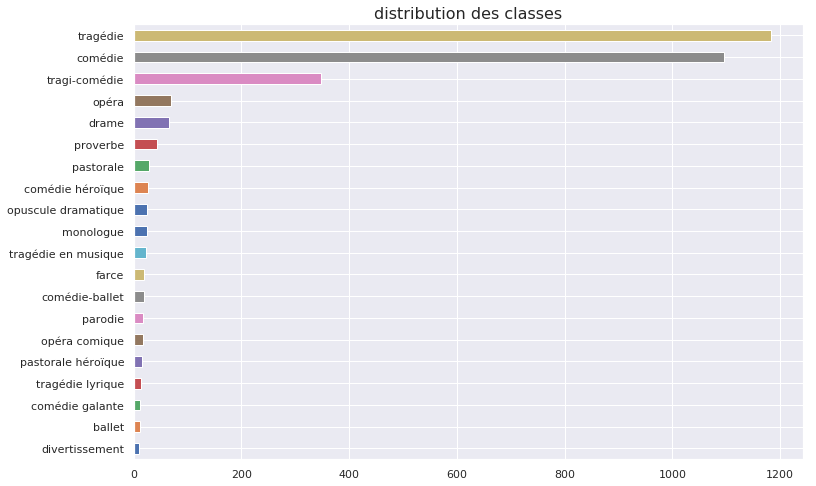

In [22]:
sns.set()

plt.figure(figsize=(12,8))

plt.title("distribution des classes",fontsize = 16)

pd.Series(data["Labels"].values).value_counts(ascending = True).plot(kind='barh')

plt.show()

In [23]:
# distribution des donnees en train et test en respectant la distribution par classe

sss = StratifiedShuffleSplit(test_size = 0.25)

acts = data["Acts"].values
labels = data["Labels"].values

for train_index, test_index in sss.split(acts,labels):
    
    X_train, X_test = acts[train_index], acts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [24]:
X_train.shape,X_test.shape

((2299,), (767,))

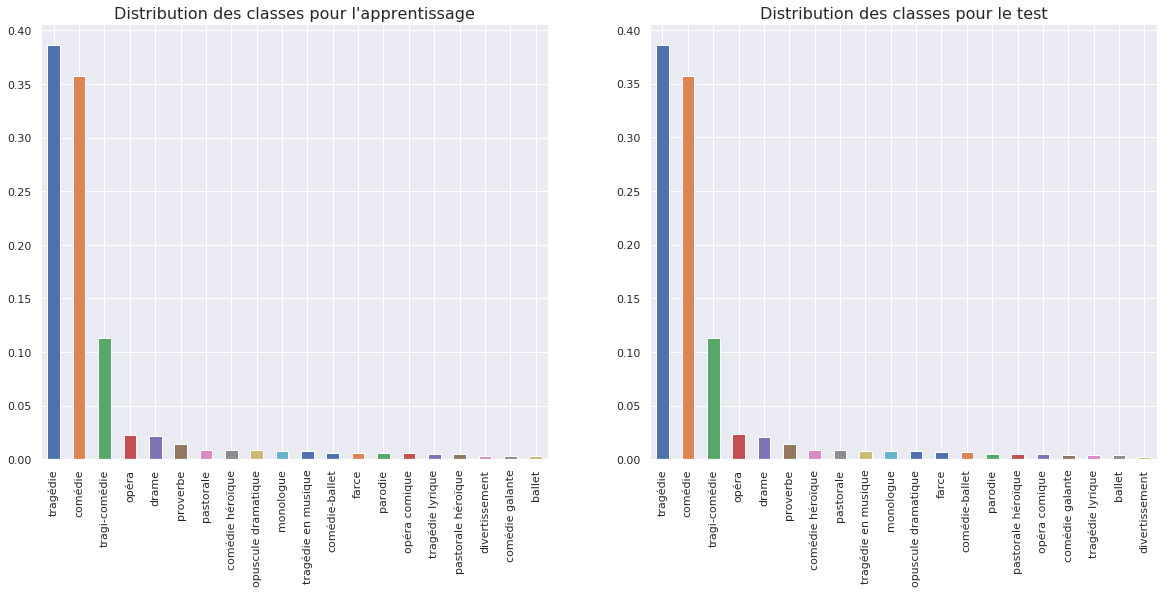

In [25]:
# verification si la distribution par classe est la meme

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.title("Distribution des classes pour l'apprentissage",fontsize = 16)
pd.Series(y_train).value_counts(normalize = True).plot(kind='bar')

plt.subplot(122)
plt.title("Distribution des classes pour le test",fontsize = 16)
pd.Series(y_test).value_counts(normalize = True).plot(kind='bar')

plt.show()

<div class="alert alert-info">
    <h2>Word Embeddings</h2>
    </div>

<p> Pour télécharger le word embedding pré entrainé, entrer à <a href= "http://fauconnier.github.io/?fbclid=IwAR0frC2KtZ79NAzeIpEcYceiNi3oiFltgYAuvMI6-H0ae0LcrIJohoLmfBA#data">ce site</a> et telecharger le premier fichier binaire (2.7 GB).<br>
Après taper ces commandes dans une shell au meme répertoire.
<ul>
    <li>git clone https://github.com/marekrei/convertvec</li>
    <li>cd convertvec/</li>
    <li>make</li>
    <li>./convertvec bin2txt /<nom_du_fichier_telecharger.bin/> output.txt</li>
</ul>
</p>   

In [26]:
# mon fichier est dans ce repertoire, il faut changer ca chez vous selon votre directoire
direct = 'convertvec/'

embeddings_index = {}

f = open(os.path.join(direct, 'output.txt'),encoding='utf-8')

r = re.compile("[0-9 -]")

# le plongemet est à la forme d'une liste, où le premier element est le nom, et le reste son embedding.
try:
    for line in f:
        try:
            values = line.split()
            word = values[0]
            
            # il y a des donnes bruités dans le plogement, je les nettoye ici, 
            # j'élimine tous qui n'est pas un caratcere numerique.
            newlist = list(filter(r.match, values[1:]))
            
            coefs = np.asarray(newlist, dtype='float32')
            
            embeddings_index[word] = coefs
        except :
            print("error")
except UnicodeDecodeError:
    print("erreur")
        
f.close()

# Il y a un probleme de lecture, on a arrive a extraire juste ce nombre d'elements
print('Found %s word vectors.' % len(embeddings_index))

erreur
Found 893466 word vectors.


In [27]:
# maxlen egale le nombre moyenne de mots par acte.
maxlen  = 2500

max_words = 50000

"""
changer data par dataP si vous voulez tester le modele sur les periodes
""" 
texts = data["Acts"].values

tokenizer = Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(texts)

sequences = np.array(tokenizer.texts_to_sequences(texts))

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

X = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

sss = StratifiedShuffleSplit(test_size = 0.25)

# utilise plabels au lieu de labels si tu veux tester sur les periodes
for train_index, test_index in sss.split(X,labels):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

Found 120453 unique tokens.


((2299, 2500), (767, 2500), (2299, 20), (767, 20))

In [28]:
# dimension de l'embedding imposée par le corpus telechargé
embedding_dim = 200

c = 0
embedding_matrix = np.zeros((max_words, embedding_dim))

# eliminer les mots vides de l'embedding car il n'existe pas dans nos donnees
for word, i in word_index.items():
    if word not in stop_words and c < max_words:
    
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[c] = embedding_vector
            c+=1
            
c

50000

In [29]:
# definir le modele 
model = Sequential()
model.add(Embedding(max_words,embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(20, activation="sigmoid"))

"""
Changer len(classes) par len(classesP) si vous voulez tester le modele sur les periodes
"""
model.add(Dense(len(classes), activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2500, 200)         10000000  
_________________________________________________________________
flatten_1 (Flatten)          (None, 500000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10000020  
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
Total params: 20,000,440
Trainable params: 20,000,440
Non-trainable params: 0
_________________________________________________________________


In [30]:
# ajouter l'embedding entrainé, commenter ces lignes pour ne pas utiliser l'embedding pré-entrainé
# il faut redefinir le modele si vous voulez essayer sans modele pré-entrainé, apres essayer avec un modele pré-entrainé
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [31]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.2)

Train on 1839 samples, validate on 460 samples
Epoch 1/50
1839/1839 [==============================] - 3s 2ms/step - loss: 2.3639 - acc: 0.3583 - val_loss: 2.2841 - val_acc: 0.3457
Epoch 2/50
1839/1839 [==============================] - 2s 952us/step - loss: 2.1324 - acc: 0.4035 - val_loss: 2.1537 - val_acc: 0.3457
Epoch 3/50
1839/1839 [==============================] - 2s 954us/step - loss: 2.0086 - acc: 0.4356 - val_loss: 2.0006 - val_acc: 0.5152
Epoch 4/50
1839/1839 [==============================] - 2s 950us/step - loss: 1.8843 - acc: 0.5443 - val_loss: 1.9368 - val_acc: 0.4217
Epoch 5/50
1839/1839 [==============================] - 2s 948us/step - loss: 1.7817 - acc: 0.5666 - val_loss: 1.8325 - val_acc: 0.4913
Epoch 6/50
1839/1839 [==============================] - 2s 954us/step - loss: 1.7143 - acc: 0.5579 - val_loss: 1.7726 - val_acc: 0.5174
Epoch 7/50
1839/1839 [==============================] - 2s 944us/step - loss: 1.6458 - acc: 0.5943 - val_loss: 1.7412 - val_acc: 0.4935
Epo

In [32]:
results = model.evaluate(X_test, y_test)
print("evaluate on test set ",results)

767/767 [==============================] - 0s 476us/step
evaluate on test set  [1.5625690845031937, 0.5554106914701797]


In [33]:
results = model.evaluate(X_train, y_train)
print("evaluate on train set ",results)

2299/2299 [==============================] - 1s 537us/step
evaluate on train set  [0.980287826802742, 0.7529360589487442]


In [34]:
y_pred = model.predict(X_test)

pr, rc, fs,_ = precision_recall_fscore_support(np.argmax(y_test.values,axis = 1), np.argmax(y_pred,axis = 1), average='micro')

In [35]:
print("precision is {}%, recall is {}% and f1 score is {}%".format(pr*100, rc*100, fs*100))

precision is 55.54106910039114%, recall is 55.54106910039114% and f1 score is 55.54106910039114%


## Tester sans embedding pré-entrainé

In [36]:
# definir le modele 
model = Sequential()
model.add(Embedding(max_words,embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(20, activation="sigmoid"))

"""
Changer len(classes) par len(classesP) si vous voulez tester le modele sur les periodes
"""
model.add(Dense(len(classes), activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.2)

y_pred = model.predict(X_test)

pr, rc, fs,_ = precision_recall_fscore_support(np.argmax(y_test.values,axis = 1), np.argmax(y_pred,axis = 1), average='micro')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2500, 200)         10000000  
_________________________________________________________________
flatten_2 (Flatten)          (None, 500000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                10000020  
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
Total params: 20,000,440
Trainable params: 20,000,440
Non-trainable params: 0
_________________________________________________________________
Train on 1839 samples, validate on 460 samples
Epoch 1/50
1839/1839 [==============================] - 3s 2ms/step - loss: 2.0173 - acc: 0.5030 - val_loss: 1.8164 - val_acc: 0.5761
Epoch 2/50
1839/1839 [==============================] - 2s 1ms/step - loss: 1.512

In [37]:
print("precision is {}%, recall is {}% and f1 score is {}%".format(pr*100, rc*100, fs*100))

precision is 73.79400260756192%, recall is 73.79400260756192% and f1 score is 73.79400260756194%
